In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import six


sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})


import anchor


from anchor import MODALITY_ORDER, MODALITY_PALETTE, MODALITY_TO_COLOR, MODALITY_TO_CMAP

%load_ext autoreload
%autoreload 2

# Figures in the notebook
%matplotlib inline

# Set random seed
np.random.seed(sum(map(ord, 'anchor')))



# Define folder to save figures
folder = 'figures/bimodality_index'
!mkdir -p $folder


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataset_name_to_folder = {#'Perfect Modalities': '../S05._Supplementary_Figure5',
                          'Maybe Bimodals': '../S06._Supplementary_Figure6'}

datatypes = 'data', 'metadata'
datasets = {name: {datatype: pd.read_csv('{}/{}.csv'.format(folder, datatype), index_col=0) 
              for datatype in datatypes} for name, folder in dataset_name_to_folder.items()}


In [12]:
def name_to_filename(name):
    return name.lower().replace(' ', '_')

for name in datasets:
    dataset_folder = '{}/{}'.format(folder, name_to_filename(name))
    ! mkdir $dataset_folder

mkdir: cannot create directory `figures/bimodality_index/maybe_bimodals': File exists


In [13]:
for name, datas in datasets.items():
    six.print_(name)
    data = datas['data']
    metadata = datas['metadata']
    six.print_(data.shape)

Maybe Bimodals
(100, 198099)


In [14]:
subset_size = 10000

In [15]:
n_subsets = int(data.shape[1]/float(subset_size))
n_subsets

19

In [16]:
palette = sns.diverging_palette(247, 0, 85, 58, 10, n=99)

In [17]:
bimodal_palette = sns.diverging_palette(247, 0, 85, 58, 10, n=99, center='dark')

Maybe Bimodals
	Subset 0 (0-10000)
	Subset 1 (10000-20000)
	Subset 2 (20000-30000)
	Subset 3 (30000-40000)
	Subset 4 (40000-50000)
	Subset 5 (50000-60000)
	Subset 6 (60000-70000)
	Subset 7 (70000-80000)
	Subset 8 (80000-90000)
	Subset 9 (90000-100000)
	Subset 10 (100000-110000)
	Subset 11 (110000-120000)
	Subset 12 (120000-130000)
	Subset 13 (130000-140000)
	Subset 14 (140000-150000)
	Subset 15 (150000-160000)
	Subset 16 (160000-170000)
	Subset 17 (170000-180000)
	Subset 18 (180000-190000)


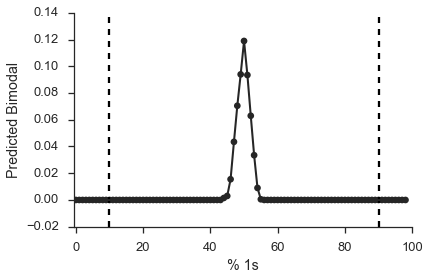

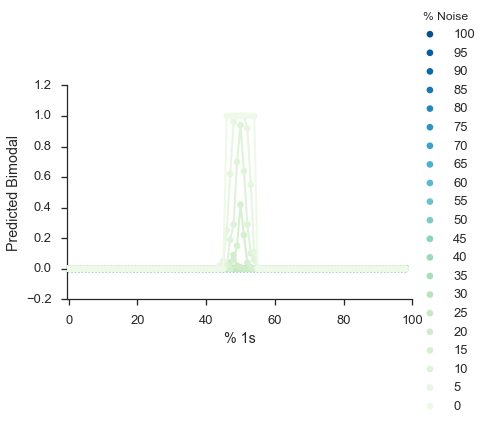

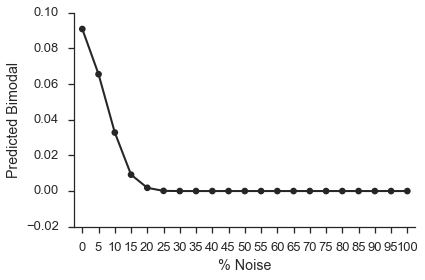

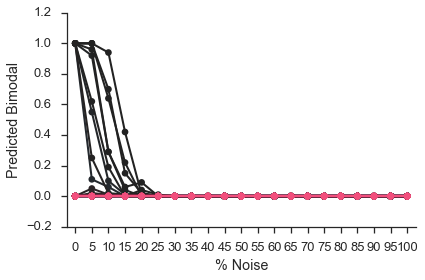

In [18]:
from sklearn.mixture import GMM

for name, datas in datasets.items():
    six.print_(name)
    data = datas['data']
    metadata = datas['metadata']
    
    dataset_folder = '{}/{}'.format(folder, name_to_filename(name))
    
    dfs = []
    
    for i in range(n_subsets):
        start = subset_size*i
        stop = min(subset_size*(i+1), data.shape[1])
        six.print_('\tSubset {} ({}-{})'.format(i, start, stop))
        subset = data.iloc[:, start:stop]
        
        gmm = GMM(n_components=2)
        gmm.fit(subset)
        means = pd.DataFrame(gmm.means_, columns=subset.columns)
        means.head()

        covars = pd.DataFrame(gmm.covars_, columns=subset.columns)
        covars.head()

        weights = pd.Series(gmm.weights_)
        weights.head()

        proportions = weights.mean()
        standardized_distance = np.abs(means.loc[0] - means.loc[1])/covars.mean()

        df = np.sqrt(proportions * (1-proportions)) * standardized_distance
        df.name = "Bimodality Index"
        dfs.append(df)
        
    bimodality_index = pd.concat(dfs, ignore_index=False)

    # Add annotation of original modality and noise percentages
    bimodality_index = metadata.join(bimodality_index)

    # Add column for when this method predicted bimodality
    bimodality_index['Predicted Bimodal'] = bimodality_index['Bimodality Index'] > 10

    g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
           data=bimodality_index, scale=0.5, color='#262626',
           aspect=1.5, ci=None)
    for ax in g.axes.flat:
        ymin, ymax = ax.get_ylim()
        ax.vlines([10, 90], ymin, ymax, linestyle='--')
    g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100), ylim=(ymin, ymax))
    g.savefig('{}_bimodals_percent_predicted_bimodal.pdf'.format(dataset_folder))

    g = sns.factorplot(x='% 1s', y='Predicted Bimodal', 
                   data=bimodality_index, scale=0.5, dodge=False,
                   aspect=1.5, ci=None, hue='% Noise', palette='GnBu_r', hue_order=np.arange(0, 101, 5)[::-1])
    g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
    # g.map_dataframe(sns.pointplot,  x='% 1s', y='Predicted Bimodal', scale=0.5, ci=None, dodge=False)
    g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

    g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                   data=bimodality_index, scale=0.5, dodge=False, legend=False,
                   aspect=1.5, ci=None, color='#262626')
    # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
    g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise.pdf'.format(dataset_folder))

    g = sns.factorplot(x='% Noise', y='Predicted Bimodal', 
                   data=bimodality_index, scale=0.5, dodge=False, legend=False,
                   aspect=1.5, ci=None, hue='% 1s', palette=bimodal_palette, hue_order=np.arange(1, 100)[::-1])
    # g.set(xticks=(0, 20, 40, 60, 80, 100), xticklabels=(0, 20, 40, 60, 80, 100))
    g.savefig('{}_bimodals_percent_predicted_bimodal_with_noise_per_percent_1.pdf'.format(dataset_folder))